In [1]:
import sys
sys.path.append('..')

In [2]:
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score

In [3]:
from spinesTS.data import BuiltInSeriesData
from spinesTS.nn import *
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error
from spinesTS.pipeline import Pipeline

In [4]:
series_data = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  1 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | Electric_Production  | date, value                                                          |
|  5 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_timestamp |
|  6 | M3_monthly_TSTS      | series_id, category, value, timestamp                        

In [5]:
cs = series_data['Electric_Production']

x_train, x_test, y_train, y_test = split_series(cs['value'], cs['value'], 128, 24, train_size=0.9)

In [6]:
x_train.shape, x_test.shape

((221, 128), (25, 128))

## rescaling

In [13]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

In [14]:
x_train_sc = sc_x.fit_transform(x_train)
x_test_sc = sc_x.transform(x_test)

y_train_sc = sc_y.fit_transform(y_train)
y_test_sc = sc_y.transform(y_test)

# StackingRNN

Using cpu backend
Epoch 1/3000  
7/7 - p0 - loss: 0.8996 - mae: 0.8494 - val_loss: 0.7952 - val_mae: 0.7952 - 0.16s/epoch - 0.023s/step
Epoch 2/3000  
7/7 - p0 - loss: 0.7324 - mae: 0.6019 - val_loss: 0.6340 - val_mae: 0.6340 - 0.17s/epoch - 0.024s/step
Epoch 3/3000  
7/7 - p0 - loss: 0.5532 - mae: 0.5480 - val_loss: 0.5145 - val_mae: 0.5145 - 0.16s/epoch - 0.022s/step
Epoch 4/3000  
7/7 - p0 - loss: 0.4846 - mae: 0.5897 - val_loss: 0.4334 - val_mae: 0.4334 - 0.17s/epoch - 0.024s/step
Epoch 5/3000  
7/7 - p1 - loss: 0.5072 - mae: 0.5534 - val_loss: 0.4478 - val_mae: 0.4478 - 0.15s/epoch - 0.022s/step
Epoch 6/3000  
7/7 - p2 - loss: 0.4892 - mae: 0.5445 - val_loss: 0.4429 - val_mae: 0.4429 - 0.15s/epoch - 0.022s/step
Epoch 7/3000  
7/7 - p0 - loss: 0.4707 - mae: 0.5389 - val_loss: 0.4227 - val_mae: 0.4227 - 0.15s/epoch - 0.021s/step
Epoch 8/3000  
7/7 - p0 - loss: 0.4552 - mae: 0.5290 - val_loss: 0.3861 - val_mae: 0.3861 - 0.14s/epoch - 0.021s/step
Epoch 9/3000  
7/7 - p0 - loss: 0.4350

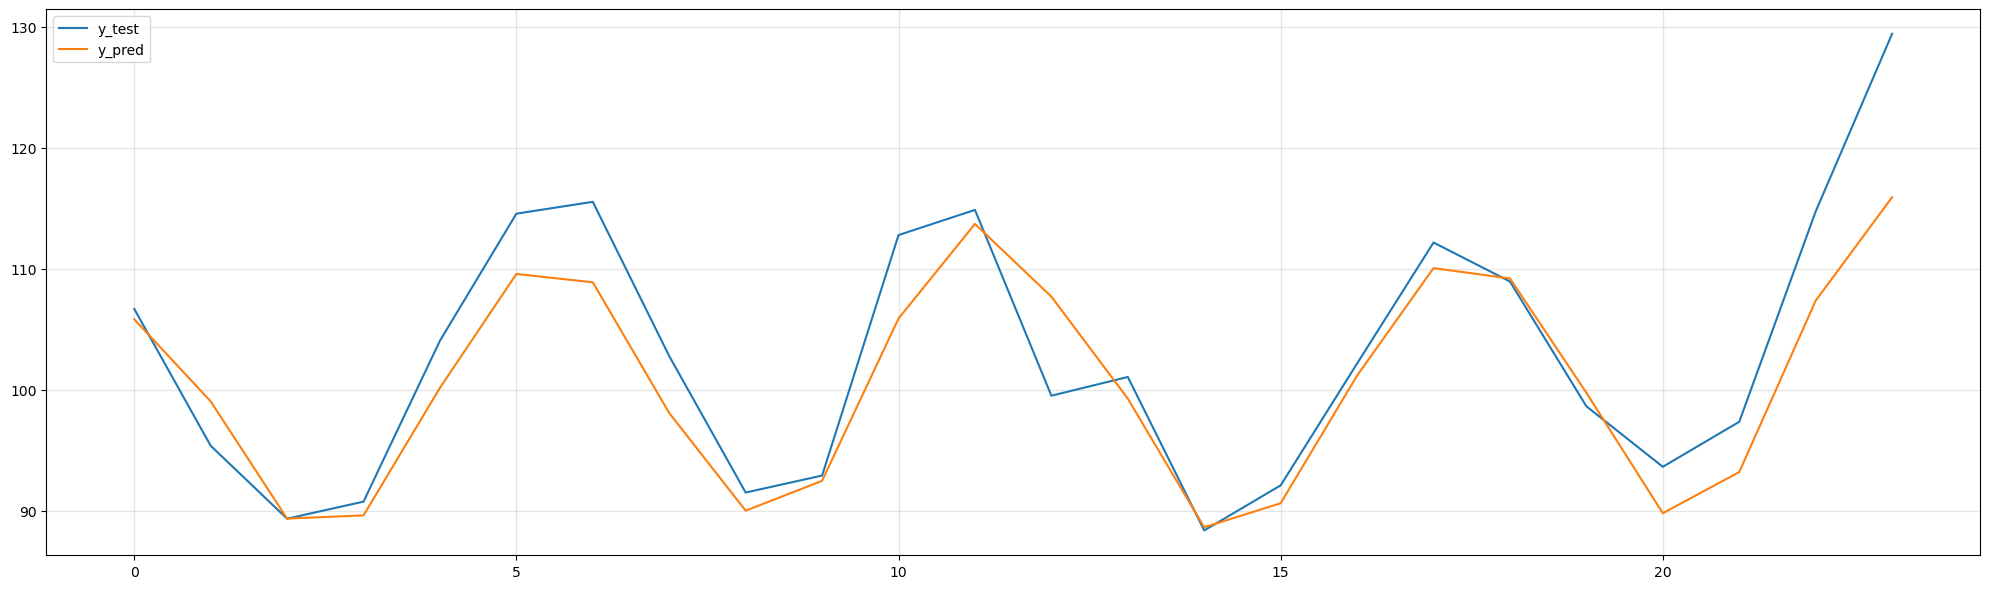

In [15]:
model = StackingRNN(128, 24, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1, diff_n=1, 
                    stack_num=2, bidirectional=True, device='cpu')
model.fit(x_train_sc, y_train_sc, eval_set=(x_test_sc[:-2], y_test_sc[:-2]), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred = model.predict(x_test_sc[-2:])
y_pred_inverse = sc_y.inverse_transform(y_pred)
print(f"r2: {r2_score(y_test[-2:].T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test[-2:], y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test[-2:], y_pred_inverse)}")
a = plot2d(y_test[-2:], y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# GAUNet

Using cpu backend
Epoch 1/3000  
7/7 - p0 - loss: 53.3352 - mae: 76.8197 - val_loss: 45.2995 - val_mae: 45.7993 - 0.03s/epoch - 0.004s/step
Epoch 2/3000  
7/7 - p0 - loss: 20.5538 - mae: 27.9572 - val_loss: 22.5764 - val_mae: 23.0686 - 0.02s/epoch - 0.002s/step
Epoch 3/3000  
7/7 - p0 - loss: 20.5696 - mae: 17.1656 - val_loss: 20.3919 - val_mae: 20.8847 - 0.02s/epoch - 0.003s/step
Epoch 4/3000  
7/7 - p0 - loss: 10.7071 - mae: 11.9884 - val_loss: 10.2146 - val_mae: 10.7016 - 0.02s/epoch - 0.003s/step
Epoch 5/3000  
7/7 - p1 - loss: 11.5219 - mae: 10.9363 - val_loss: 11.8908 - val_mae: 12.3825 - 0.02s/epoch - 0.003s/step
Epoch 6/3000  
7/7 - p2 - loss: 11.6049 - mae: 9.2262 - val_loss: 11.7066 - val_mae: 12.1974 - 0.02s/epoch - 0.003s/step
Epoch 7/3000  
7/7 - p0 - loss: 9.0595 - mae: 8.6239 - val_loss: 9.5941 - val_mae: 10.0876 - 0.02s/epoch - 0.002s/step
Epoch 8/3000  
7/7 - p1 - loss: 9.4297 - mae: 8.6531 - val_loss: 9.6874 - val_mae: 10.1733 - 0.01s/epoch - 0.002s/step
Epoch 9/3000 

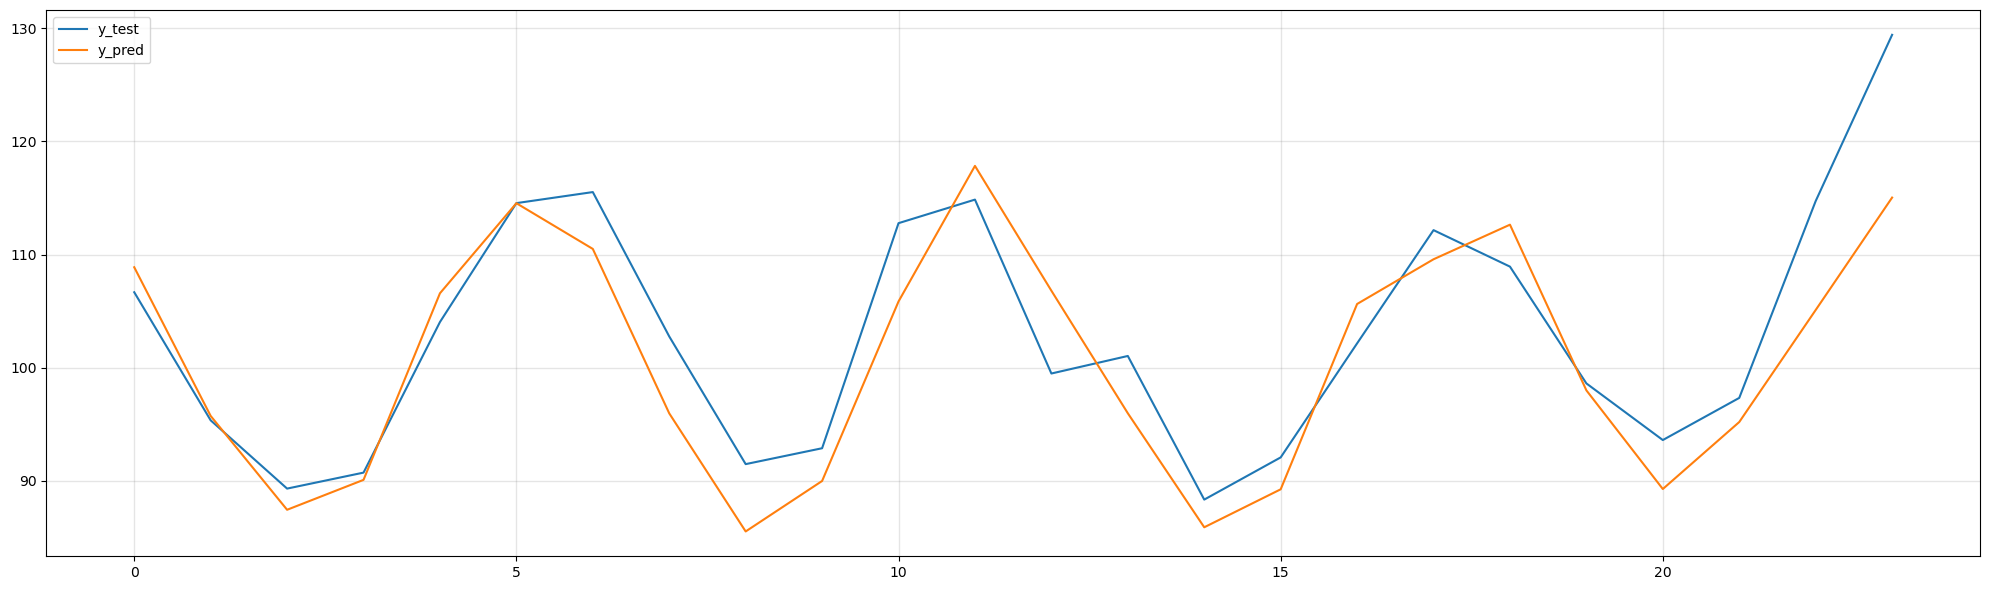

In [29]:
model = GAUNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, level=1, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test[:-2], y_test[:-2]), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = model.predict(x_test[-2:])
print(f"r2: {r2_score(y_test[-2:].T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test[-2:], y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test[-2:], y_pred_inverse)}")
a = plot2d(y_test[-2:], y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# Time2VecNet

Using cpu backend
Epoch 1/3000  
7/7 - p0 - loss: 37.0098 - mae: 60.6064 - val_loss: 33.7448 - val_mae: 34.2415 - 0.02s/epoch - 0.003s/step
Epoch 2/3000  
7/7 - p0 - loss: 18.3686 - mae: 21.5017 - val_loss: 19.0866 - val_mae: 19.5825 - 0.02s/epoch - 0.003s/step
Epoch 3/3000  
7/7 - p0 - loss: 15.1406 - mae: 14.1449 - val_loss: 14.8390 - val_mae: 15.3312 - 0.02s/epoch - 0.003s/step
Epoch 4/3000  
7/7 - p0 - loss: 9.7309 - mae: 10.3342 - val_loss: 9.6148 - val_mae: 10.1086 - 0.02s/epoch - 0.003s/step
Epoch 5/3000  
7/7 - p1 - loss: 10.7287 - mae: 9.8425 - val_loss: 11.2408 - val_mae: 11.7311 - 0.02s/epoch - 0.003s/step
Epoch 6/3000  
7/7 - p0 - loss: 9.1361 - mae: 8.0640 - val_loss: 8.8114 - val_mae: 9.3032 - 0.02s/epoch - 0.003s/step
Epoch 7/3000  
7/7 - p1 - loss: 8.9113 - mae: 8.6539 - val_loss: 9.6064 - val_mae: 10.0969 - 0.02s/epoch - 0.003s/step
Epoch 8/3000  
7/7 - p2 - loss: 9.1574 - mae: 7.8717 - val_loss: 8.9426 - val_mae: 9.4332 - 0.02s/epoch - 0.003s/step
Epoch 9/3000  
7/7 -

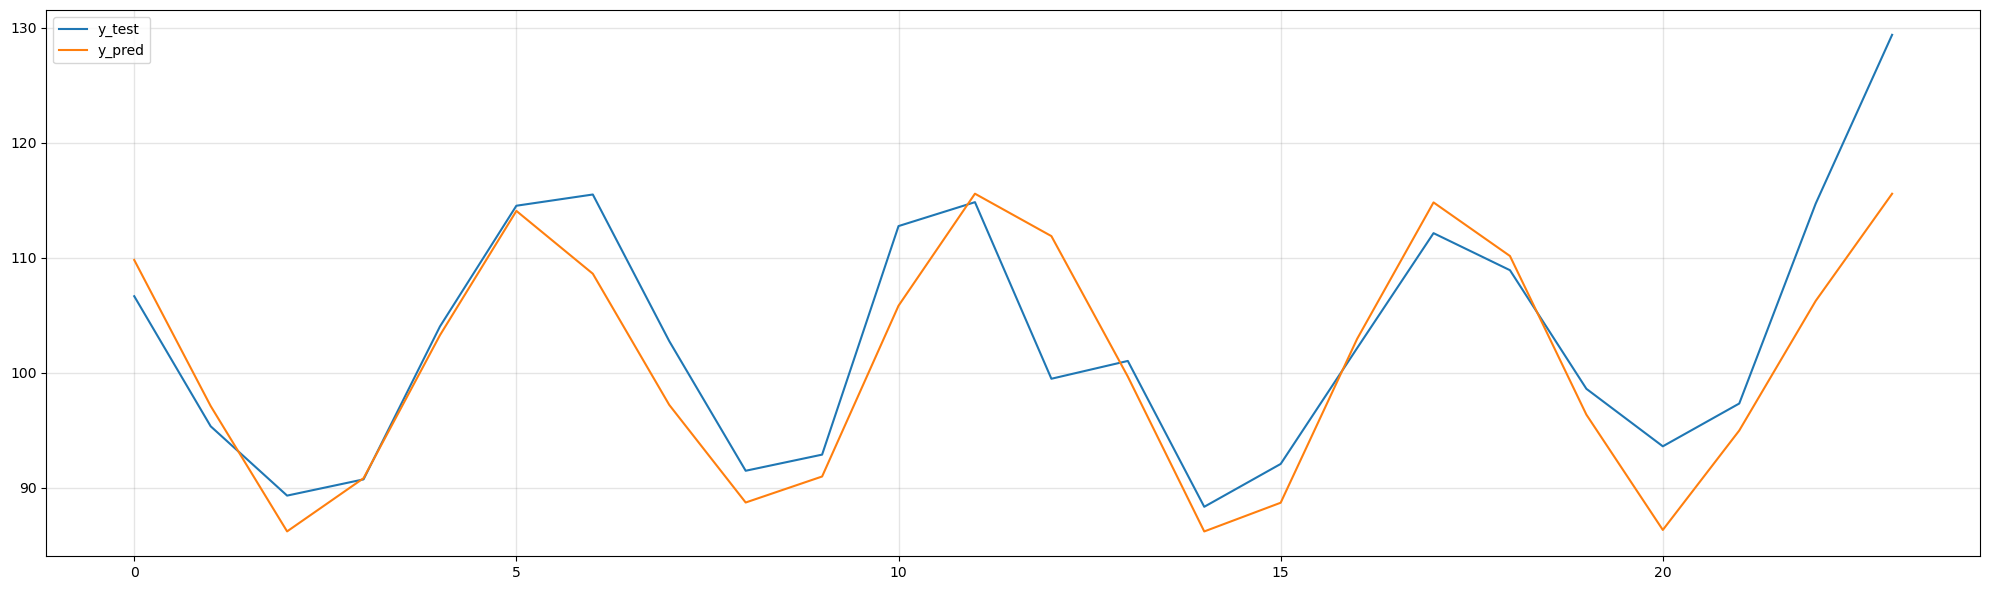

In [31]:
model = Time2VecNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test[:-2], y_test[:-2]), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler='ReduceLROnPlateau')
y_pred_inverse = model.predict(x_test[-2:])

print(f"r2: {r2_score(y_test[-2:].T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test[-2:], y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test[-2:], y_pred_inverse)}")
a = plot2d(y_test[-2:], y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))